In [1]:
%set_env CUDA_VISIBLE_DEVICES=1

from timeit import default_timer
from src.models.ResNet import *
from src.utils.trainer import *
from src.utils.tools import *
from src.utils.splitNN import *
from src.utils.dataloader import *
from torch.multiprocessing import set_start_method
from torch.optim.lr_scheduler import MultiStepLR, StepLR
from torch.optim import Adam, SGD
from torch import tensor
from torch import nn

import matplotlib.pyplot as plt
import pandas as pd
import syft as sy
import torch
import os
import gc

env: CUDA_VISIBLE_DEVICES=1
{'apple': 0, 'aquarium_fish': 1, 'baby': 2, 'bear': 3, 'beaver': 4, 'bed': 5, 'bee': 6, 'beetle': 7, 'bicycle': 8, 'bottle': 9, 'bowl': 10, 'boy': 11, 'bridge': 12, 'bus': 13, 'butterfly': 14, 'camel': 15, 'can': 16, 'castle': 17, 'caterpillar': 18, 'cattle': 19, 'chair': 20, 'chimpanzee': 21, 'clock': 22, 'cloud': 23, 'cockroach': 24, 'couch': 25, 'crab': 26, 'crocodile': 27, 'cup': 28, 'dinosaur': 29, 'dolphin': 30, 'elephant': 31, 'flatfish': 32, 'forest': 33, 'fox': 34, 'girl': 35, 'hamster': 36, 'house': 37, 'kangaroo': 38, 'keyboard': 39, 'lamp': 40, 'lawn_mower': 41, 'leopard': 42, 'lion': 43, 'lizard': 44, 'lobster': 45, 'man': 46, 'maple_tree': 47, 'motorcycle': 48, 'mountain': 49, 'mouse': 50, 'mushroom': 51, 'oak_tree': 52, 'orange': 53, 'orchid': 54, 'otter': 55, 'palm_tree': 56, 'pear': 57, 'pickup_truck': 58, 'pine_tree': 59, 'plain': 60, 'plate': 61, 'poppy': 62, 'porcupine': 63, 'possum': 64, 'rabbit': 65, 'raccoon': 66, 'ray': 67, 'road': 68

In [2]:
torch.manual_seed(0)

client_ids = list(range(0, 5))
data_paths = {}
for c in client_ids:
    data_paths[c] = f'data/clients/client{c+1}'

save_path = 'results/fashion-mnist/non-iid'

# To get around the PyTorch issue described by me at:
# https://github.com/OpenMined/PySyft/issues/3848
# This, however, leads to inefficient use of GPU memory
# and problems related to multiprocessing

torch.set_default_tensor_type(torch.cuda.FloatTensor)
hook = sy.TorchHook(torch)

server_model = ResNetServer18(num_classes=10)
client_model = ResNetClient(num_channels=1)

criterion = nn.NLLLoss(reduction='mean')

optim = SGD
optim_params = {
    'lr' : 0.1, 
    'momentum' : 0.9, 
    'weight_decay' :  0.0001
}

scheduler = MultiStepLR
scheduler_params = {
    'milestones': [50],
    'gamma': 0.2, 
}

dataloader_params = {
    'shuffle' : True,
    'num_workers' : 8,
}

batch_size = 512
batch_sizes = {
    0: int(0.4 * batch_size),
    1: int(0.3 * batch_size),
    2: int(0.1 * batch_size),
    3: int(0.1 * batch_size),
    4: int(0.1 * batch_size),
}

# PyTorch multiprocessing errors out with DataLoader tensors created on GPU 
# (as with torch.set_default_tensor_type(torch.cuda.FloatTensor)) and num_workers > 0.
# Therefore, we check if this is the case, and if so, change the spawn method. 
# More details at https://pytorch.org/docs/master/notes/multiprocessing.html
if torch.tensor([0]).is_cuda and dataloader_params['num_workers'] > 0:
    set_start_method('spawn', force=True)

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Workers are automatically put on to the appropriate devices and clients
server = init_worker('server', server_model, hook, device, requires_grad=True) 

clients = {}
for c in client_ids:
    clients[c] = init_worker('client_'+str(c), client_model, hook, device, requires_grad=True)

splitNN = SplitNN(clients, server)
criterion = criterion.to(device)

# Optimizers
server_optim = optim(splitNN.server.parameters(), **optim_params)
client_optims = {}
for c, client in splitNN.clients.items():
    client_optims[c] = optim(client.parameters(), **optim_params)

split_optim = SplitOptimizer(client_optims, server_optim)

# Schedulers
server_scheduler = scheduler(split_optim.server, **scheduler_params)
client_schedulers = {}
for c, client_optim in split_optim.clients.items():
    client_schedulers[c] = scheduler(client_optim, **scheduler_params)

split_scheduler = SplitScheduler(client_schedulers, server_scheduler)
    
# Get the data
dataloaders = {}
for c in client_ids:
    dataloaders[c] = {}
    dataloaders[c]['train'] = FashionMNIST_dataloader(data_paths[c], batch_size=batch_sizes[c], 
                                               train=True, **dataloader_params)
    dataloaders[c]['val'] = FashionMNIST_dataloader(data_paths[c], batch_size=batch_sizes[c], 
                                             train=False, **dataloader_params)

trainer = SplitTrainer(client_ids=client_ids, splitNN=splitNN, split_optim=split_optim,
                       split_scheduler=split_scheduler, dataloaders=dataloaders, criterion=criterion, 
                       num_epochs=100, save_path=save_path, verbose=2, device=device)

In [ ]:
stats = trainer.train_alternate(train_clts=client_ids, val_clts=client_ids)

Training epoch 1. Learning rate: 0.1 --------------------------------------------------
Client 0. Loss: 1.559, accuracy: 20.10%
Client 1. Loss: 0.821, accuracy: 16.99%
Client 2. Loss: 0.513, accuracy: 0.00%
Client 3. Loss: 0.398, accuracy: 0.00%
Client 4. Loss: 0.889, accuracy: 0.00%


Client 0. Loss: 1.242, accuracy: 0.00%
Client 1. Loss: 0.536, accuracy: 54.25%
Client 2. Loss: 0.305, accuracy: 0.00%
Client 3. Loss: 0.300, accuracy: 0.00%
Client 4. Loss: 0.264, accuracy: 0.00%


Client 0. Loss: 1.426, accuracy: 0.00%
Client 1. Loss: 0.716, accuracy: 3.27%
Client 2. Loss: 0.186, accuracy: 0.00%
Client 3. Loss: 0.214, accuracy: 0.00%
Client 4. Loss: 0.136, accuracy: 92.16%


Client 0. Loss: 0.772, accuracy: 29.41%
Client 1. Loss: 0.531, accuracy: 62.09%
Client 2. Loss: 0.254, accuracy: 1.96%
Client 3. Loss: 0.216, accuracy: 7.84%
Client 4. Loss: 0.279, accuracy: 0.00%


Client 0. Loss: 0.771, accuracy: 28.92%
Client 1. Loss: 0.376, accuracy: 68.63%
Client 2. Loss: 0.181, accuracy: 13.73

Client 1. Loss: 0.096, accuracy: 88.89%
Client 2. Loss: 0.000, accuracy: 100.00%
Client 3. Loss: 0.001, accuracy: 100.00%
Client 4. Loss: 0.000, accuracy: 100.00%


Client 0. Loss: 0.396, accuracy: 55.88%
Client 1. Loss: 0.111, accuracy: 84.97%
Client 2. Loss: 0.001, accuracy: 100.00%
Client 3. Loss: 0.001, accuracy: 100.00%
Client 4. Loss: 0.000, accuracy: 100.00%


Client 0. Loss: 0.408, accuracy: 52.94%
Client 1. Loss: 0.130, accuracy: 84.31%
Client 2. Loss: 0.001, accuracy: 100.00%
Client 3. Loss: 0.001, accuracy: 100.00%
Client 4. Loss: 0.000, accuracy: 100.00%


Sample 0 out of 20. Loss: 1.214, accuracy: 45.59%
Sample 10 out of 20. Loss: 1.200, accuracy: 45.59%
Val results for client 0, epoch 3: loss=1.20515, accuracy=47.64153

Sample 0 out of 20. Loss: 0.338, accuracy: 90.20%
Sample 10 out of 20. Loss: 0.248, accuracy: 91.50%
Val results for client 1, epoch 3: loss=0.29660, accuracy=88.68965

Sample 0 out of 20. Loss: 0.005, accuracy: 100.00%
Sample 10 out of 20. Loss: 0.005, ac

Client 3. Loss: 0.001, accuracy: 100.00%
Client 4. Loss: 0.000, accuracy: 100.00%


Client 0. Loss: 0.344, accuracy: 63.24%
Client 1. Loss: 0.042, accuracy: 96.08%
Client 2. Loss: 0.000, accuracy: 100.00%
Client 3. Loss: 0.001, accuracy: 100.00%
Client 4. Loss: 0.001, accuracy: 100.00%


Client 0. Loss: 0.354, accuracy: 61.76%
Client 1. Loss: 0.076, accuracy: 88.89%
Client 2. Loss: 0.001, accuracy: 100.00%
Client 3. Loss: 0.001, accuracy: 100.00%
Client 4. Loss: 0.000, accuracy: 100.00%


Client 0. Loss: 0.357, accuracy: 56.37%
Client 1. Loss: 0.061, accuracy: 92.16%
Client 2. Loss: 0.000, accuracy: 100.00%
Client 3. Loss: 0.001, accuracy: 100.00%
Client 4. Loss: 0.001, accuracy: 100.00%


Client 0. Loss: 0.319, accuracy: 66.18%
Client 1. Loss: 0.064, accuracy: 93.46%
Client 2. Loss: 0.000, accuracy: 100.00%
Client 3. Loss: 0.001, accuracy: 100.00%
Client 4. Loss: 0.000, accuracy: 100.00%


Client 0. Loss: 0.279, accuracy: 70.59%
Client 1. Loss: 0.047, accuracy: 92.81%
Client 2. Loss: 

Client 4. Loss: 0.000, accuracy: 100.00%


Client 0. Loss: 0.290, accuracy: 70.10%
Client 1. Loss: 0.061, accuracy: 92.81%
Client 2. Loss: 0.000, accuracy: 100.00%
Client 3. Loss: 0.000, accuracy: 100.00%
Client 4. Loss: 0.000, accuracy: 100.00%


Client 0. Loss: 0.306, accuracy: 64.22%
Client 1. Loss: 0.044, accuracy: 96.08%
Client 2. Loss: 0.000, accuracy: 100.00%
Client 3. Loss: 0.000, accuracy: 100.00%
Client 4. Loss: 0.000, accuracy: 100.00%


Sample 0 out of 20. Loss: 0.846, accuracy: 63.24%
Sample 10 out of 20. Loss: 0.756, accuracy: 67.16%
Val results for client 0, epoch 8: loss=0.73986, accuracy=69.76993

Sample 0 out of 20. Loss: 0.186, accuracy: 93.46%
Sample 10 out of 20. Loss: 0.288, accuracy: 87.58%
Val results for client 1, epoch 8: loss=0.23791, accuracy=90.76956

Sample 0 out of 20. Loss: 0.003, accuracy: 100.00%
Sample 10 out of 20. Loss: 0.002, accuracy: 100.00%
Val results for client 2, epoch 8: loss=0.00211, accuracy=100.00000

Sample 0 out of 20. Loss: 0.003, accu

Client 1. Loss: 0.044, accuracy: 96.08%
Client 2. Loss: 0.000, accuracy: 100.00%
Client 3. Loss: 0.000, accuracy: 100.00%
Client 4. Loss: 0.001, accuracy: 100.00%


Client 0. Loss: 0.301, accuracy: 69.12%
Client 1. Loss: 0.033, accuracy: 97.39%
Client 2. Loss: 0.000, accuracy: 100.00%
Client 3. Loss: 0.000, accuracy: 100.00%
Client 4. Loss: 0.000, accuracy: 100.00%


Client 0. Loss: 0.181, accuracy: 84.31%
Client 1. Loss: 0.044, accuracy: 96.08%
Client 2. Loss: 0.000, accuracy: 100.00%
Client 3. Loss: 0.000, accuracy: 100.00%
Client 4. Loss: 0.000, accuracy: 100.00%


Client 0. Loss: 0.269, accuracy: 74.51%
Client 1. Loss: 0.056, accuracy: 93.46%
Client 2. Loss: 0.000, accuracy: 100.00%
Client 3. Loss: 0.001, accuracy: 100.00%
Client 4. Loss: 0.003, accuracy: 100.00%


Client 0. Loss: 0.256, accuracy: 73.53%
Client 1. Loss: 0.042, accuracy: 94.12%
Client 2. Loss: 0.000, accuracy: 100.00%
Client 3. Loss: 0.000, accuracy: 100.00%
Client 4. Loss: 0.000, accuracy: 100.00%


Client 0. Loss:

Client 2. Loss: 0.000, accuracy: 100.00%
Client 3. Loss: 0.000, accuracy: 100.00%
Client 4. Loss: 0.000, accuracy: 100.00%


Client 0. Loss: 0.269, accuracy: 73.04%
Client 1. Loss: 0.050, accuracy: 92.81%
Client 2. Loss: 0.000, accuracy: 100.00%
Client 3. Loss: 0.000, accuracy: 100.00%
Client 4. Loss: 0.000, accuracy: 100.00%


Sample 0 out of 20. Loss: 0.685, accuracy: 67.65%
Sample 10 out of 20. Loss: 0.734, accuracy: 70.59%
Val results for client 0, epoch 13: loss=0.65962, accuracy=72.29365

Sample 0 out of 20. Loss: 0.190, accuracy: 92.81%
Sample 10 out of 20. Loss: 0.118, accuracy: 96.08%
Val results for client 1, epoch 13: loss=0.16726, accuracy=93.43348

Sample 0 out of 20. Loss: 0.001, accuracy: 100.00%
Sample 10 out of 20. Loss: 0.001, accuracy: 100.00%
Val results for client 2, epoch 13: loss=0.00124, accuracy=100.00000

Sample 0 out of 20. Loss: 0.003, accuracy: 100.00%
Sample 10 out of 20. Loss: 0.002, accuracy: 100.00%
Val results for client 3, epoch 13: loss=0.00207, accu

Client 3. Loss: 0.000, accuracy: 100.00%
Client 4. Loss: 0.000, accuracy: 100.00%


Client 0. Loss: 0.217, accuracy: 79.41%
Client 1. Loss: 0.038, accuracy: 96.08%
Client 2. Loss: 0.000, accuracy: 100.00%
Client 3. Loss: 0.000, accuracy: 100.00%
Client 4. Loss: 0.000, accuracy: 100.00%


Client 0. Loss: 0.244, accuracy: 75.00%
Client 1. Loss: 0.028, accuracy: 96.73%
Client 2. Loss: 0.000, accuracy: 100.00%
Client 3. Loss: 0.000, accuracy: 100.00%
Client 4. Loss: 0.000, accuracy: 100.00%


Client 0. Loss: 0.213, accuracy: 81.37%
Client 1. Loss: 0.041, accuracy: 94.77%
Client 2. Loss: 0.001, accuracy: 100.00%
Client 3. Loss: 0.000, accuracy: 100.00%
Client 4. Loss: 0.000, accuracy: 100.00%


Client 0. Loss: 0.221, accuracy: 79.90%
Client 1. Loss: 0.029, accuracy: 97.39%
Client 2. Loss: 0.000, accuracy: 100.00%
Client 3. Loss: 0.000, accuracy: 100.00%
Client 4. Loss: 0.000, accuracy: 100.00%


Client 0. Loss: 0.203, accuracy: 82.35%
Client 1. Loss: 0.042, accuracy: 95.42%
Client 2. Loss: 

Client 4. Loss: 0.000, accuracy: 100.00%


Client 0. Loss: 0.179, accuracy: 82.35%
Client 1. Loss: 0.028, accuracy: 95.42%
Client 2. Loss: 0.000, accuracy: 100.00%
Client 3. Loss: 0.000, accuracy: 100.00%
Client 4. Loss: 0.000, accuracy: 100.00%


Sample 0 out of 20. Loss: 0.773, accuracy: 69.61%
Sample 10 out of 20. Loss: 0.842, accuracy: 63.73%
Val results for client 0, epoch 18: loss=0.87083, accuracy=63.90180

Sample 0 out of 20. Loss: 0.170, accuracy: 91.50%
Sample 10 out of 20. Loss: 0.132, accuracy: 94.12%
Val results for client 1, epoch 18: loss=0.17190, accuracy=93.64326

Sample 0 out of 20. Loss: 0.002, accuracy: 100.00%
Sample 10 out of 20. Loss: 0.002, accuracy: 100.00%
Val results for client 2, epoch 18: loss=0.00184, accuracy=100.00000

Sample 0 out of 20. Loss: 0.002, accuracy: 100.00%
Sample 10 out of 20. Loss: 0.001, accuracy: 100.00%
Val results for client 3, epoch 18: loss=0.00211, accuracy=100.00000

Sample 0 out of 20. Loss: 0.002, accuracy: 100.00%
Sample 10 out o

Client 0. Loss: 0.196, accuracy: 80.39%
Client 1. Loss: 0.035, accuracy: 92.81%
Client 2. Loss: 0.000, accuracy: 100.00%
Client 3. Loss: 0.000, accuracy: 100.00%
Client 4. Loss: 0.000, accuracy: 100.00%


Client 0. Loss: 0.197, accuracy: 78.43%
Client 1. Loss: 0.024, accuracy: 98.04%
Client 2. Loss: 0.000, accuracy: 100.00%
Client 3. Loss: 0.000, accuracy: 100.00%
Client 4. Loss: 0.000, accuracy: 100.00%


Client 0. Loss: 0.203, accuracy: 75.49%
Client 1. Loss: 0.032, accuracy: 96.73%
Client 2. Loss: 0.000, accuracy: 100.00%
Client 3. Loss: 0.000, accuracy: 100.00%
Client 4. Loss: 0.000, accuracy: 100.00%


Client 0. Loss: 0.223, accuracy: 77.45%
Client 1. Loss: 0.035, accuracy: 97.39%
Client 2. Loss: 0.000, accuracy: 100.00%
Client 3. Loss: 0.000, accuracy: 100.00%
Client 4. Loss: 0.000, accuracy: 100.00%


Client 0. Loss: 0.200, accuracy: 78.43%
Client 1. Loss: 0.020, accuracy: 97.39%
Client 2. Loss: 0.000, accuracy: 100.00%
Client 3. Loss: 0.000, accuracy: 100.00%
Client 4. Loss: 0.

Client 1. Loss: 0.028, accuracy: 96.08%
Client 2. Loss: 0.000, accuracy: 100.00%
Client 3. Loss: 0.000, accuracy: 100.00%
Client 4. Loss: 0.000, accuracy: 100.00%


Sample 0 out of 20. Loss: 0.616, accuracy: 71.08%
Sample 10 out of 20. Loss: 0.768, accuracy: 67.65%
Val results for client 0, epoch 23: loss=0.70887, accuracy=70.09409

Sample 0 out of 20. Loss: 0.056, accuracy: 99.35%
Sample 10 out of 20. Loss: 0.077, accuracy: 96.08%
Val results for client 1, epoch 23: loss=0.12383, accuracy=95.37318

Sample 0 out of 20. Loss: 0.001, accuracy: 100.00%
Sample 10 out of 20. Loss: 0.001, accuracy: 100.00%
Val results for client 2, epoch 23: loss=0.00122, accuracy=100.00000

Sample 0 out of 20. Loss: 0.002, accuracy: 100.00%
Sample 10 out of 20. Loss: 0.002, accuracy: 100.00%
Val results for client 3, epoch 23: loss=0.00237, accuracy=100.00000

Sample 0 out of 20. Loss: 0.002, accuracy: 100.00%
Sample 10 out of 20. Loss: 0.002, accuracy: 100.00%
Val results for client 4, epoch 23: loss=0.002

Client 2. Loss: 0.000, accuracy: 100.00%
Client 3. Loss: 0.000, accuracy: 100.00%
Client 4. Loss: 0.000, accuracy: 100.00%


Client 0. Loss: 0.183, accuracy: 80.39%
Client 1. Loss: 0.039, accuracy: 94.77%
Client 2. Loss: 0.000, accuracy: 100.00%
Client 3. Loss: 0.000, accuracy: 100.00%
Client 4. Loss: 0.000, accuracy: 100.00%


Client 0. Loss: 0.161, accuracy: 83.33%
Client 1. Loss: 0.029, accuracy: 95.42%
Client 2. Loss: 0.000, accuracy: 100.00%
Client 3. Loss: 0.000, accuracy: 100.00%
Client 4. Loss: 0.000, accuracy: 100.00%


Client 0. Loss: 0.160, accuracy: 87.25%
Client 1. Loss: 0.028, accuracy: 96.08%
Client 2. Loss: 0.000, accuracy: 100.00%
Client 3. Loss: 0.000, accuracy: 100.00%
Client 4. Loss: 0.000, accuracy: 100.00%


Client 0. Loss: 0.179, accuracy: 79.90%
Client 1. Loss: 0.020, accuracy: 97.39%
Client 2. Loss: 0.000, accuracy: 100.00%
Client 3. Loss: 0.000, accuracy: 100.00%
Client 4. Loss: 0.000, accuracy: 100.00%


Client 0. Loss: 0.153, accuracy: 86.76%
Client 1. Loss:

Client 3. Loss: 0.001, accuracy: 100.00%
Client 4. Loss: 0.000, accuracy: 100.00%


Sample 0 out of 20. Loss: 0.621, accuracy: 75.49%
Sample 10 out of 20. Loss: 0.532, accuracy: 79.41%
Val results for client 0, epoch 28: loss=0.53954, accuracy=78.22660

Sample 0 out of 20. Loss: 0.119, accuracy: 94.12%
Sample 10 out of 20. Loss: 0.067, accuracy: 97.39%
Val results for client 1, epoch 28: loss=0.10550, accuracy=96.15750

Sample 0 out of 20. Loss: 0.001, accuracy: 100.00%
Sample 10 out of 20. Loss: 0.001, accuracy: 100.00%
Val results for client 2, epoch 28: loss=0.00097, accuracy=100.00000

Sample 0 out of 20. Loss: 0.001, accuracy: 100.00%
Sample 10 out of 20. Loss: 0.002, accuracy: 100.00%
Val results for client 3, epoch 28: loss=0.00177, accuracy=100.00000

Sample 0 out of 20. Loss: 0.002, accuracy: 100.00%
Sample 10 out of 20. Loss: 0.001, accuracy: 100.00%
Val results for client 4, epoch 28: loss=0.00131, accuracy=100.00000

Val results global, epoch 28: loss=0.24787, accuracy=90.1

Client 4. Loss: 0.000, accuracy: 100.00%


Client 0. Loss: 0.209, accuracy: 78.92%
Client 1. Loss: 0.013, accuracy: 98.69%
Client 2. Loss: 0.000, accuracy: 100.00%
Client 3. Loss: 0.001, accuracy: 100.00%
Client 4. Loss: 0.000, accuracy: 100.00%


Client 0. Loss: 0.172, accuracy: 85.29%
Client 1. Loss: 0.021, accuracy: 96.08%
Client 2. Loss: 0.000, accuracy: 100.00%
Client 3. Loss: 0.000, accuracy: 100.00%
Client 4. Loss: 0.001, accuracy: 100.00%


Client 0. Loss: 0.163, accuracy: 84.80%
Client 1. Loss: 0.032, accuracy: 96.08%
Client 2. Loss: 0.000, accuracy: 100.00%
Client 3. Loss: 0.000, accuracy: 100.00%
Client 4. Loss: 0.000, accuracy: 100.00%


Client 0. Loss: 0.169, accuracy: 81.86%
Client 1. Loss: 0.019, accuracy: 98.04%
Client 2. Loss: 0.000, accuracy: 100.00%
Client 3. Loss: 0.000, accuracy: 100.00%
Client 4. Loss: 0.000, accuracy: 100.00%


Client 0. Loss: 0.181, accuracy: 82.35%
Client 1. Loss: 0.025, accuracy: 97.39%
Client 2. Loss: 0.000, accuracy: 100.00%
Client 3. Loss: 

Sample 0 out of 20. Loss: 0.665, accuracy: 73.04%
Sample 10 out of 20. Loss: 0.623, accuracy: 75.00%
Val results for client 0, epoch 33: loss=0.64293, accuracy=75.39058

Sample 0 out of 20. Loss: 0.074, accuracy: 98.04%
Sample 10 out of 20. Loss: 0.118, accuracy: 95.42%
Val results for client 1, epoch 33: loss=0.12506, accuracy=95.51550

Sample 0 out of 20. Loss: 0.001, accuracy: 100.00%
Sample 10 out of 20. Loss: 0.001, accuracy: 100.00%
Val results for client 2, epoch 33: loss=0.00080, accuracy=100.00000

Sample 0 out of 20. Loss: 0.001, accuracy: 100.00%
Sample 10 out of 20. Loss: 0.001, accuracy: 100.00%
Val results for client 3, epoch 33: loss=0.00097, accuracy=100.00000

Sample 0 out of 20. Loss: 0.002, accuracy: 100.00%
Sample 10 out of 20. Loss: 0.002, accuracy: 100.00%
Val results for client 4, epoch 33: loss=0.00212, accuracy=100.00000

Val results global, epoch 33: loss=0.29508, accuracy=88.81088

Training epoch 34. Learning rate: 0.1 ----------------------------------------

Client 1. Loss: 0.026, accuracy: 96.73%
Client 2. Loss: 0.000, accuracy: 100.00%
Client 3. Loss: 0.002, accuracy: 100.00%
Client 4. Loss: 0.000, accuracy: 100.00%


Client 0. Loss: 0.179, accuracy: 81.37%
Client 1. Loss: 0.025, accuracy: 96.08%
Client 2. Loss: 0.000, accuracy: 100.00%
Client 3. Loss: 0.000, accuracy: 100.00%
Client 4. Loss: 0.000, accuracy: 100.00%


Client 0. Loss: 0.191, accuracy: 79.41%
Client 1. Loss: 0.020, accuracy: 98.69%
Client 2. Loss: 0.000, accuracy: 100.00%
Client 3. Loss: 0.000, accuracy: 100.00%
Client 4. Loss: 0.000, accuracy: 100.00%


Client 0. Loss: 0.172, accuracy: 81.37%
Client 1. Loss: 0.041, accuracy: 96.08%
Client 2. Loss: 0.000, accuracy: 100.00%
Client 3. Loss: 0.000, accuracy: 100.00%
Client 4. Loss: 0.000, accuracy: 100.00%


Client 0. Loss: 0.188, accuracy: 79.90%
Client 1. Loss: 0.036, accuracy: 96.08%
Client 2. Loss: 0.000, accuracy: 100.00%
Client 3. Loss: 0.000, accuracy: 100.00%
Client 4. Loss: 0.000, accuracy: 100.00%


Client 0. Loss:

Val results for client 0, epoch 38: loss=0.53753, accuracy=78.96743

Sample 0 out of 20. Loss: 0.112, accuracy: 95.42%
Sample 10 out of 20. Loss: 0.100, accuracy: 97.39%
Val results for client 1, epoch 38: loss=0.10374, accuracy=96.11533

Sample 0 out of 20. Loss: 0.001, accuracy: 100.00%
Sample 10 out of 20. Loss: 0.001, accuracy: 100.00%
Val results for client 2, epoch 38: loss=0.00089, accuracy=100.00000

Sample 0 out of 20. Loss: 0.002, accuracy: 100.00%
Sample 10 out of 20. Loss: 0.002, accuracy: 100.00%
Val results for client 3, epoch 38: loss=0.00167, accuracy=100.00000

Sample 0 out of 20. Loss: 0.001, accuracy: 100.00%
Sample 10 out of 20. Loss: 0.001, accuracy: 100.00%
Val results for client 4, epoch 38: loss=0.00106, accuracy=100.00000

Val results global, epoch 38: loss=0.24650, accuracy=90.42157

Training epoch 39. Learning rate: 0.1 --------------------------------------------------
Client 0. Loss: 0.159, accuracy: 85.29%
Client 1. Loss: 0.018, accuracy: 97.39%
Client 2. 

Client 4. Loss: 0.000, accuracy: 100.00%


Client 0. Loss: 0.171, accuracy: 86.27%
Client 1. Loss: 0.028, accuracy: 97.39%
Client 2. Loss: 0.000, accuracy: 100.00%
Client 3. Loss: 0.000, accuracy: 100.00%
Client 4. Loss: 0.000, accuracy: 100.00%


Client 0. Loss: 0.179, accuracy: 80.88%
Client 1. Loss: 0.028, accuracy: 98.04%
Client 2. Loss: 0.000, accuracy: 100.00%
Client 3. Loss: 0.000, accuracy: 100.00%
Client 4. Loss: 0.001, accuracy: 100.00%


Client 0. Loss: 0.190, accuracy: 78.92%
Client 1. Loss: 0.034, accuracy: 95.42%
Client 2. Loss: 0.000, accuracy: 100.00%
Client 3. Loss: 0.000, accuracy: 100.00%
Client 4. Loss: 0.001, accuracy: 100.00%


Client 0. Loss: 0.162, accuracy: 85.29%
Client 1. Loss: 0.035, accuracy: 94.12%
Client 2. Loss: 0.000, accuracy: 100.00%
Client 3. Loss: 0.000, accuracy: 100.00%
Client 4. Loss: 0.000, accuracy: 100.00%


Client 0. Loss: 0.156, accuracy: 83.82%
Client 1. Loss: 0.018, accuracy: 98.04%
Client 2. Loss: 0.000, accuracy: 100.00%
Client 3. Loss: 

Sample 10 out of 20. Loss: 0.085, accuracy: 98.04%
Val results for client 1, epoch 43: loss=0.08948, accuracy=96.70145

Sample 0 out of 20. Loss: 0.001, accuracy: 100.00%
Sample 10 out of 20. Loss: 0.001, accuracy: 100.00%
Val results for client 2, epoch 43: loss=0.00121, accuracy=100.00000

Sample 0 out of 20. Loss: 0.003, accuracy: 100.00%
Sample 10 out of 20. Loss: 0.002, accuracy: 100.00%
Val results for client 3, epoch 43: loss=0.00259, accuracy=100.00000

Sample 0 out of 20. Loss: 0.002, accuracy: 100.00%
Sample 10 out of 20. Loss: 0.002, accuracy: 100.00%
Val results for client 4, epoch 43: loss=0.00197, accuracy=100.00000

Val results global, epoch 43: loss=0.27159, accuracy=89.84251

Training epoch 44. Learning rate: 0.1 --------------------------------------------------
Client 0. Loss: 0.167, accuracy: 82.35%
Client 1. Loss: 0.038, accuracy: 94.12%
Client 2. Loss: 0.000, accuracy: 100.00%
Client 3. Loss: 0.000, accuracy: 100.00%
Client 4. Loss: 0.000, accuracy: 100.00%


Clie

Client 2. Loss: 0.000, accuracy: 100.00%
Client 3. Loss: 0.000, accuracy: 100.00%
Client 4. Loss: 0.000, accuracy: 100.00%


Client 0. Loss: 0.149, accuracy: 81.86%
Client 1. Loss: 0.022, accuracy: 97.39%
Client 2. Loss: 0.000, accuracy: 100.00%
Client 3. Loss: 0.000, accuracy: 100.00%
Client 4. Loss: 0.000, accuracy: 100.00%


Client 0. Loss: 0.103, accuracy: 89.71%
Client 1. Loss: 0.042, accuracy: 94.77%
Client 2. Loss: 0.000, accuracy: 100.00%
Client 3. Loss: 0.000, accuracy: 100.00%
Client 4. Loss: 0.000, accuracy: 100.00%


Client 0. Loss: 0.140, accuracy: 83.33%
Client 1. Loss: 0.035, accuracy: 96.73%
Client 2. Loss: 0.001, accuracy: 100.00%
Client 3. Loss: 0.000, accuracy: 100.00%
Client 4. Loss: 0.000, accuracy: 100.00%


Client 0. Loss: 0.141, accuracy: 85.78%
Client 1. Loss: 0.028, accuracy: 97.39%
Client 2. Loss: 0.000, accuracy: 100.00%
Client 3. Loss: 0.000, accuracy: 100.00%
Client 4. Loss: 0.000, accuracy: 100.00%


Client 0. Loss: 0.168, accuracy: 82.84%
Client 1. Loss:

Sample 0 out of 20. Loss: 0.002, accuracy: 100.00%
Sample 10 out of 20. Loss: 0.002, accuracy: 100.00%
Val results for client 2, epoch 48: loss=0.00178, accuracy=100.00000

Sample 0 out of 20. Loss: 0.004, accuracy: 100.00%
Sample 10 out of 20. Loss: 0.004, accuracy: 100.00%
Val results for client 3, epoch 48: loss=0.00388, accuracy=100.00000

Sample 0 out of 20. Loss: 0.003, accuracy: 100.00%
Sample 10 out of 20. Loss: 0.003, accuracy: 100.00%
Val results for client 4, epoch 48: loss=0.00273, accuracy=100.00000

Val results global, epoch 48: loss=0.25380, accuracy=89.90544

Training epoch 49. Learning rate: 0.1 --------------------------------------------------
Client 0. Loss: 0.129, accuracy: 88.73%
Client 1. Loss: 0.014, accuracy: 98.04%
Client 2. Loss: 0.000, accuracy: 100.00%
Client 3. Loss: 0.000, accuracy: 100.00%
Client 4. Loss: 0.000, accuracy: 100.00%


Client 0. Loss: 0.160, accuracy: 82.35%
Client 1. Loss: 0.016, accuracy: 98.04%
Client 2. Loss: 0.000, accuracy: 100.00%
Cli

Client 4. Loss: 0.000, accuracy: 100.00%


Client 0. Loss: 0.131, accuracy: 88.73%
Client 1. Loss: 0.013, accuracy: 98.69%
Client 2. Loss: 0.000, accuracy: 100.00%
Client 3. Loss: 0.000, accuracy: 100.00%
Client 4. Loss: 0.000, accuracy: 100.00%


Client 0. Loss: 0.127, accuracy: 86.27%
Client 1. Loss: 0.013, accuracy: 98.04%
Client 2. Loss: 0.000, accuracy: 100.00%
Client 3. Loss: 0.000, accuracy: 100.00%
Client 4. Loss: 0.000, accuracy: 100.00%


Client 0. Loss: 0.105, accuracy: 89.22%
Client 1. Loss: 0.036, accuracy: 97.39%
Client 2. Loss: 0.000, accuracy: 100.00%
Client 3. Loss: 0.000, accuracy: 100.00%
Client 4. Loss: 0.000, accuracy: 100.00%


Client 0. Loss: 0.124, accuracy: 87.75%
Client 1. Loss: 0.022, accuracy: 96.73%
Client 2. Loss: 0.000, accuracy: 100.00%
Client 3. Loss: 0.000, accuracy: 100.00%
Client 4. Loss: 0.000, accuracy: 100.00%


Client 0. Loss: 0.138, accuracy: 85.78%
Client 1. Loss: 0.012, accuracy: 98.69%
Client 2. Loss: 0.000, accuracy: 100.00%
Client 3. Loss: 

In [5]:
def plot_val_loss(stats, save_path):
    val = stats['val']
    val_acc = pd.DataFrame(val['accuracy'])
    val_acc['Epoch'] = val_acc.index.values
    ax = val_acc.plot(x='Epoch', y=client_ids, kind='line')
    ax.set_ylabel("Accuracy")
    ax.legend([f"Client {i}" for i in client_ids])
    ax.figure.savefig(os.path.join(save_path, 'val_acc.png'))
    
    val_acc = pd.DataFrame(val['loss'])
    val_acc['Epoch'] = val_acc.index.values
    ax = val_acc.plot(x='Epoch', y=client_ids, kind='line')
    ax.set_ylabel("Loss")
    ax.legend([f"Client {i}" for i in client_ids])
    ax.figure.savefig(os.path.join(save_path, 'val_loss.png'))

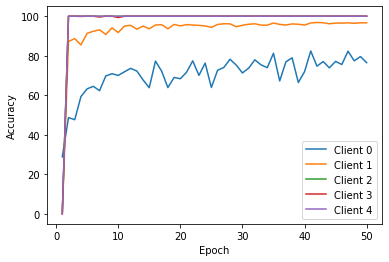

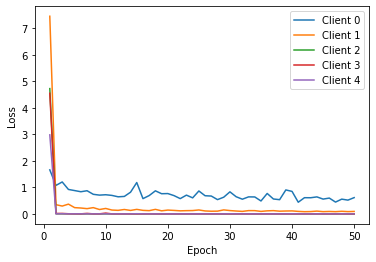

In [6]:
stats = torch.load('results/fashion-mnist/non-iid/epoch_50/server_trained_on_client_4.pth')['stats']
plot_val_loss(stats, save_path)

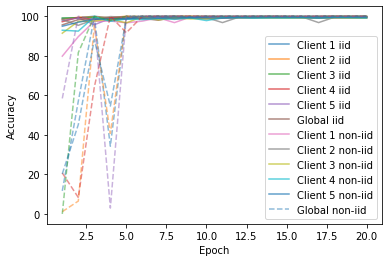

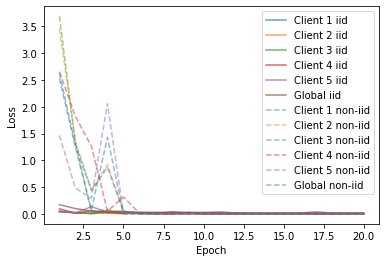

In [36]:
# Partition Fashion-MNIST into non-iid clients
# Distribution of classes to clients: 
# 0 <- ['T-shirt', 'pullover', 'coat', 'shirt']
# 1 <- ['sandals', 'sneakers', 'ankle boots']
# 2 <- ['trousers']
# 3 <- ['dress']
# 4 <- ['bag']

# Class -> Client Map
client_map = {
    0: 0,
    1: 2,
    2: 0,
    3: 3, 
    4: 0,
    5: 1, 
    6: 0, 
    7: 1, 
    8: 4,
    9: 1,  
}

train = torch.load('data/FashionMNIST/processed/training.pt')
test = torch.load('data/FashionMNIST/processed/test.pt')

X_train, y_train = train
X_test, y_test = test

data = {
    'train': {
        'X': X_train,
        'y': y_train,
    },
    'test': {
        'X': X_test,
        'y': y_test,
    }
}

client_data = {}
for c in range(5):
    client_data[c] = {}
    for mode in ['train', 'test']:
        client_data[c][mode] = {}
        client_data[c][mode]['X'] = []
        client_data[c][mode]['y'] = []
        client_data[c][mode]['path'] = None

# Partition
for c in range(10):
    for mode in ['train', 'test']:
        X = data[mode]['X']
        y = data[mode]['y']
        mask = (y == c)
        
        folder_path = f'data/clients/client{client_map[c]+1}/Fashion-MNIST/processed'
        path = os.path.join(folder_path, ('test.pt' if mode == 'test' else 'training.pt'))
        a
        if not os.path.exists(folder_path):
            os.makedirs(folder_path)
        
        client_data[client_map[c]][mode]['X'].append(X[mask])
        client_data[client_map[c]][mode]['y'].append(y[mask])
        client_data[client_map[c]][mode]['path'] = path

# Save
for c in range(5):
    for mode in ['train', 'test']:
        X = torch.cat(client_data[c][mode]['X'], dim=0)
        y = torch.cat(client_data[c][mode]['y'], dim=0)
        
        path = client_data[c][mode]['path']
        
        torch.save((X, y), path)
        
# Validate
for c in range(5):
    for mode in ['train', 'test']:
        folder_path = f'data/clients/client{c+1}/Fashion-MNIST/processed'
        path = os.path.join(folder_path, ('test.pt' if mode == 'test' else 'training.pt'))
        X, y = torch.load(path)
        
        print(c, mode, 'X: ', X.size())
        print(c, mode, 'y: ', y.size())
        print('\n')